In [10]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [11]:
'''
    -> Identificar apenas o ventriculo cerébrais
    - inicialmente remover o osso
'''

'\n    -> Identificar apenas o ventriculo cerébrais\n    - inicialmente remover o osso\n'

In [12]:
big = (20,20)
mid = (15,15)
small = (10,10)

In [25]:
def convertToUInt8(src, currDepth=None):
    if currDepth is None:
        currWindowWidth = np.iinfo(src.dtype).max+1
    else:
        currWindowWidth = 1 << currDepth
    newDepth = 8
    newWindowWidth = 1 << newDepth
    widthMultiplier = currWindowWidth/newWindowWidth
    dst = src.astype('float128')
    dst *= widthMultiplier
    return dst.astype('uint8')

def applyWindow(src, start, end=None, stick=True):
    currWindowWidth = np.iinfo(src.dtype).max + 1
    if end is None:
        end = np.max(src)
    newWindowWidth = end - start + 1
    widthMultiplier = currWindowWidth/newWindowWidth
    dst = src.astype('float128')
    dst[dst < start] = start
    dst[dst > end] = end if stick else start
    dst -= start
    dst *= widthMultiplier
    return dst.astype(src.dtype)


def plotImage(img, size=(5, 5), title='window'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap='gray')


def compareTwoImages(a, b, size=(10, 10)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)
    ax[0].imshow(a, cmap='gray')
    ax[1].imshow(b, cmap='gray')
    plt.show()


def getFrequencyArray(array, plot=True):
    val, count = np.unique(array, return_counts=True)
    if plot:
        plt.plot(val, count)
        plt.show()
    return val, count

In [14]:
def ApplyBandṕassFilter(src, start, end = None, plot = False):
    if end is None:
        end = np.max(src)
    whitePixelValue = np.iinfo(src.dtype).max
    dst = src.copy()
    dst[(src < start) | (src > end)] = 0
    dst[(start <= src) & (src <= end)] = whitePixelValue
    if plot:
        compareTwoImages(src, dst)
    return dst

In [15]:
# load the DICOM files
dcm_path = './dicom-files/arq3/pt2'

files = []

for f in os.listdir(dcm_path):
    filename = os.path.join(dcm_path, f)
    if filename[-3:] == 'dcm':
        files.append(pydicom.dcmread(filename))

In [16]:
# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

slices = sorted(slices, key=lambda s: s.SliceLocation)


In [18]:
elementRect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
elementCross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

/tmp/ipykernel_10131/3686130592.py:11: RuntimeWarning: invalid value encountered in cast
  return dst.astype('uint8')


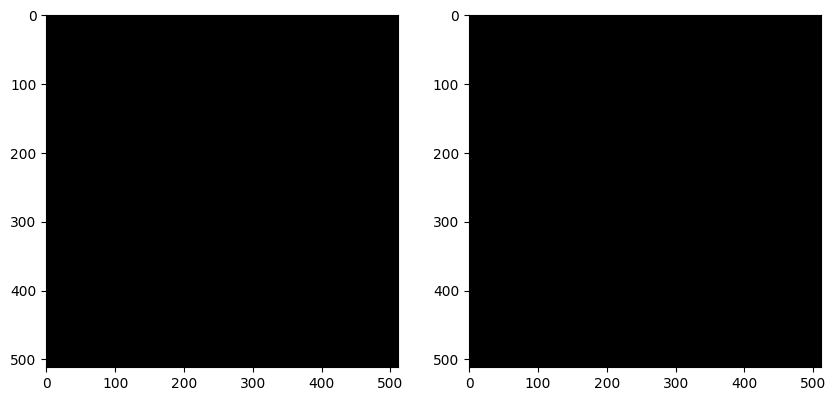

In [26]:
slice = 90
original = slices[slice].pixel_array
windowed = ApplyBandṕassFilter(original, 1100)
maskBone = cv2.bitwise_not(cv2.dilate(windowed, elementRect, iterations=40)).astype('uint16') * (1 << 8)
compareTwoImages(windowed, maskBone)

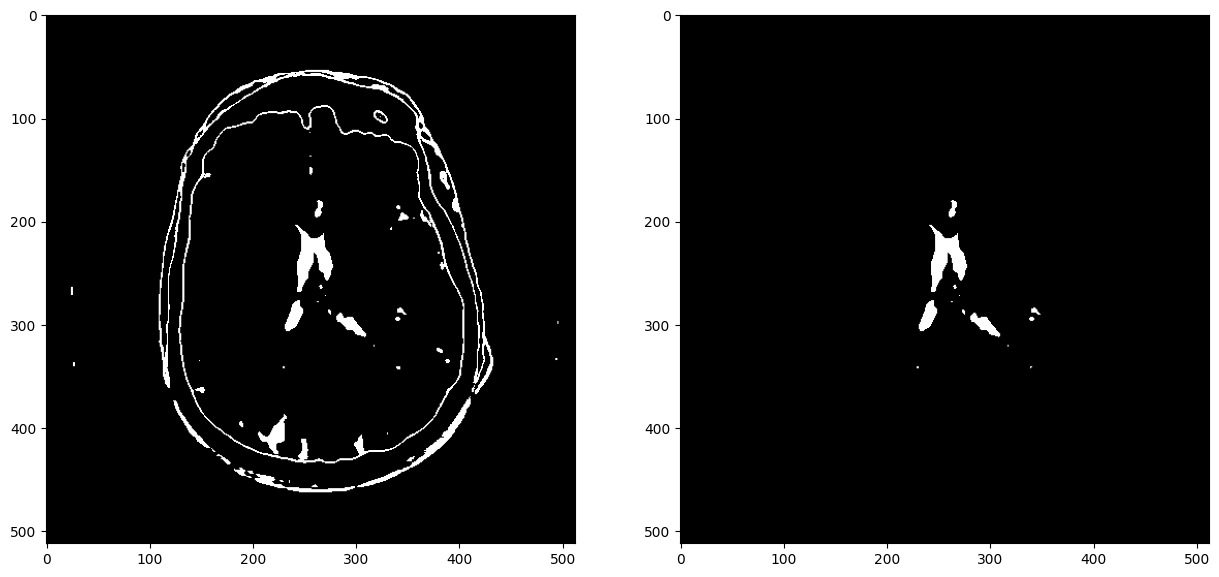

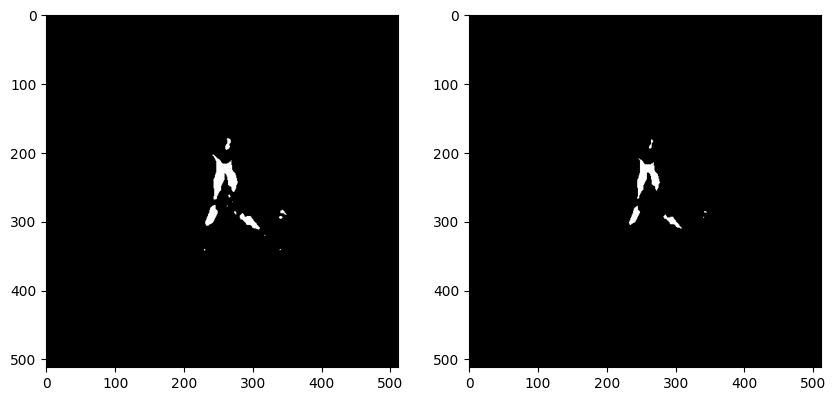

In [20]:
original = slices[slice].pixel_array
windowed = applyWindow(original, 1000, 1100, stick=False)
kernel = np.ones((5,5),np.float32)/25
windowed3 = cv2.filter2D(windowed,-1,kernel)
filtered = ApplyBandṕassFilter(windowed3, 15000, 30000)
compareTwoImages(filtered, filtered & maskBone, mid)
mask = cv2.erode(filtered & maskBone, elementRect, iterations=1)
compareTwoImages(maskBone & filtered, mask)

In [21]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.drawContours(windowed.copy().astype('uint8'), contours, -1, (0, 255, 0), 2)
compareTwoImages(windowed,contour_image, big)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [ ]:
# original = slices[85].pixel_array

# # Capturar ventriculo
# start = 1015
# end = 1035
# plotImage(cv2.inRange(original, start, end))

In [ ]:
# Ventriculo
# img = applyWindow(original, 1035, 1070)
# plotImage(img)

# Osso
# img = applyWindow(slices[85].pixel_array, 1150, 1151)
# plotImage(img)

In [ ]:


# img = applyWindow(slices[85].pixel_array, 1050, 2048)
# plotImage(img)

In [ ]:
# Creating 3D representation of scan with the slice set
# bit_deph = slices[0].BitsStored
# print(bit_deph)
# rep3d_shape = [*slices[0].pixel_array.shape, len(slices)]
# rep3d = np.zeros(rep3d_shape)
# for idx, slice in enumerate(slices):
#     img = applyWindow(slice.pixel_array.copy(), window_start, window_end)
#     rep3d[:, :, idx] = img

# resize_factor = 512/rep3d_shape[-1]

In [ ]:
# idx = 150
# pv0 = np.array(rep3d[:,:,int(idx/resize_factor)], dtype=np.uint16)
# pv1 = np.array(rep3d[:,idx,:], dtype=np.uint16)
# pv2 = np.array(rep3d[idx,:,:], dtype=np.uint16)
# pv1 = cv2.resize(pv1, (512, 512), interpolation=cv2.INTER_AREA)
# pv2 = cv2.resize(pv2, (512, 512), interpolation=cv2.INTER_AREA)
# plotImage(pv0)
# plotImage(pv1)
# plotImage(pv2)

In [ ]:
# for pg in range(150, 300, 20):
#     pv0 = np.array(rep3d[:,:,int(pg/resize_factor)], dtype=np.uint16)
#     pv0 = cv2.resize(pv0, (512, 512), interpolation=cv2.INTER_AREA)
#     plot(pv0)
#     pv0 = np.array(rep3d[:,pg,:], dtype=np.uint16)
#     pv0 = cv2.resize(pv0, (512, 512), interpolation=cv2.INTER_AREA)
#     plot(pv0)
#     pv0 = np.array(rep3d[pg,:,:], dtype=np.uint16)
#     pv0 = cv2.resize(pv0, (512, 512), interpolation=cv2.INTER_AREA)
#     plot(pv0)


In [ ]:
# mask = cv2.inRange(pv0, 20480, 1 << 16 -1)
# cv2.imshow('window', cv2.bitwise_and(pv0, pv0, mask = mask))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# mask = cv2.inRange(pv1, 20480, 1 << 16 -1)
# cv2.imshow('window', cv2.bitwise_and(pv1, pv1, mask = mask))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# mask = cv2.inRange(pv2, 20480, 1 << 16 -1)
# cv2.imshow('window', cv2.bitwise_and(pv2, pv2, mask = mask))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# for ini in range(0, 1 << 16 - 1, 2048):
#     mask = cv2.inRange(pv2, ini, 1 << 16 - 1)
#     cv2.imshow('window', mask)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [ ]:

# cv2.imshow('window', pv1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imshow('window', pv2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()